## Monterey Match Window Grid Search

In [ ]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Preparation

In [1]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import contextily as cx
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [38]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Data Tables

### Historical

In [4]:
poly_historical = pd.read_csv('../data/monterey_window_historical.csv', low_memory=False)
poly_historical['time'] = pd.to_datetime(poly_historical['time'])
poly_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156850 entries, 0 to 156849
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   field_id     156850 non-null  object        
 1   crop         156850 non-null  int64         
 2   time         156850 non-null  datetime64[ns]
 3   actual_et    156850 non-null  float64       
 4   actual_eto   156850 non-null  float64       
 5   actual_etof  156850 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.2+ MB


In [5]:
poly_historical['time'].max()

Timestamp('2024-08-02 00:00:00')

### Forecasting Table

In [6]:
# Gather current forecast data for the county
match_unaligned_table = pd.DataFrame()
files = Path(f"../data/forecasts/match_sample/0.0.3/polygon/monterey/sampled").glob("*.csv")

for file in files:
    # splits into [$date, 'window', $match_window, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    data["match_window"] = parts[2]
    match_unaligned_table = pd.concat([data, match_unaligned_table], ignore_index=True)

match_unaligned_table['forecasting_date'] = pd.to_datetime(match_unaligned_table['forecasting_date'])
match_unaligned_table['time'] = pd.to_datetime(match_unaligned_table['time'])
match_unaligned_table.head()

,field_id,crop,time,expected_et,expected_eto,expected_etof,forecasting_date,match_window
0,CA_244148,69,2024-01-01,0.705,0.918,0.768,2024-07-08,180
1,CA_244148,69,2024-01-02,0.353,0.459,0.770,2024-07-08,180
2,CA_244148,69,2024-01-03,0.708,0.918,0.771,2024-07-08,180
3,CA_244148,69,2024-01-04,1.491,1.928,0.773,2024-07-08,180
4,CA_244148,69,2024-01-05,1.067,1.377,0.775,2024-07-08,180


### Full Table Merge

In [8]:
match_dt = poly_historical.loc[(poly_historical['time'].dt.year == 2024), :]
match_dt = match_dt.merge(match_unaligned_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time', 'match_window']).reset_index()
match_dt

,forecasting_date,field_id,crop,time,match_window,actual_et,actual_eto,actual_etof,expected_et,expected_eto,expected_etof
0,2024-07-08,CA_244148,69,2024-01-01,180,0.705,0.918,0.768,0.705,0.918,0.768
1,2024-07-08,CA_244148,69,2024-01-02,180,0.353,0.459,0.770,0.353,0.459,0.770
2,2024-07-08,CA_244148,69,2024-01-03,180,0.708,0.918,0.771,0.708,0.918,0.771
3,2024-07-08,CA_244148,69,2024-01-04,180,1.491,1.928,0.773,1.491,1.928,0.773
4,2024-07-08,CA_244148,69,2024-01-05,180,1.067,1.377,0.775,1.067,1.377,0.775
...,...,...,...,...,...,...,...,...,...,...,...
494095,2024-07-01,CA_257950,47,2024-12-27,60,NaN,NaN,NaN,0.996,1.179,0.846
494096,2024-07-01,CA_257950,47,2024-12-28,60,NaN,NaN,NaN,0.911,1.082,0.842
494097,2024-07-01,CA_257950,47,2024-12-29,60,NaN,NaN,NaN,0.854,1.017,0.838
494098,2024-07-01,CA_257950,47,2024-12-30,60,NaN,NaN,NaN,0.777,0.928,0.836


## Reference Tables

In [16]:
# Climatology
poly_historical["doy"] = poly_historical["time"].dt.dayofyear
climatology = poly_historical.groupby(["field_id", "crop", "doy"])[["actual_et", "actual_eto", "actual_etof"]].agg("mean").reset_index()
climatology.head()

,field_id,crop,doy,actual_et,actual_eto,actual_etof
0,CA_244148,69,1,0.645111,0.986556,0.671111
1,CA_244148,69,2,0.729222,1.090000,0.670556
2,CA_244148,69,3,0.778222,1.173333,0.669444
3,CA_244148,69,4,0.892889,1.364000,0.668889
4,CA_244148,69,5,0.716889,1.062778,0.681222


In [17]:
# 2024 avgs for normalization
avgs = poly_historical.loc[(poly_historical["time"].dt.year == 2024), :].groupby(["field_id", "crop"])[["actual_et", "actual_eto", "actual_etof"]].agg("mean").reset_index()
avgs.head()

,field_id,crop,actual_et,actual_eto,actual_etof
0,CA_244148,69,4.078572,4.290395,0.957614
1,CA_244207,47,2.330307,4.356693,0.620986
2,CA_244216,47,3.292372,4.451209,0.777181
3,CA_244473,47,4.424321,4.034242,1.055898
4,CA_244988,47,2.228316,4.080986,0.622702


## Error Metric Calculation

### Field Metrics

In [14]:
analysis_end_date = datetime(year=2024, month=7, day=29)

In [18]:
window_metrics_unaligned = (match_dt[(match_dt['time'] > match_dt['forecasting_date']) & (match_dt['time'] < (match_dt['forecasting_date']) + timedelta(days=7)) & (match_dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date', 'match_window'])[list(match_dt.columns)]
                .apply(eval_metrics, normalize=True, climatology_ref=climatology, avgs_ref=avgs))
window_metrics_unaligned.reset_index().to_csv('../data/metrics/monterey_window_poly_metrics.csv', index=False)

/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib

In [29]:
window_metrics_unaligned = pd.read_csv('../data/metrics/monterey_window_poly_metrics.csv').drop(columns='level_2')
window_metrics_unaligned['forecasting_date'] = pd.to_datetime(window_metrics_unaligned['forecasting_date'])
window_metrics_unaligned.head()

,forecasting_date,match_window,field_id,crop,mae,rmse,corr,bias,skill_score,variable
0,2024-06-03,180,CA_244148,69,0.03,0.03,0.99,0.03,0.99,ETof
1,2024-06-03,180,CA_244207,47,0.17,0.16,-0.99,0.14,-1.00,ETof
2,2024-06-03,180,CA_244216,47,0.47,0.42,-1.00,0.47,-1.00,ETof
3,2024-06-03,180,CA_244473,47,0.50,0.51,0.99,0.50,-1.00,ETof
4,2024-06-03,180,CA_244988,47,0.22,0.17,0.99,-0.22,-1.00,ETof


# Visualization

In [30]:
metrics_long = window_metrics_unaligned.reset_index().melt(id_vars=['forecasting_date', 'match_window', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [31]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   forecasting_date  10800 non-null  datetime64[ns]
 1   match_window      10800 non-null  int64         
 2   field_id          10800 non-null  object        
 3   crop              10800 non-null  int64         
 4   variable          10800 non-null  object        
 5   stat              10800 non-null  object        
 6   value             10800 non-null  float64       
 7   name              10800 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 675.1+ KB


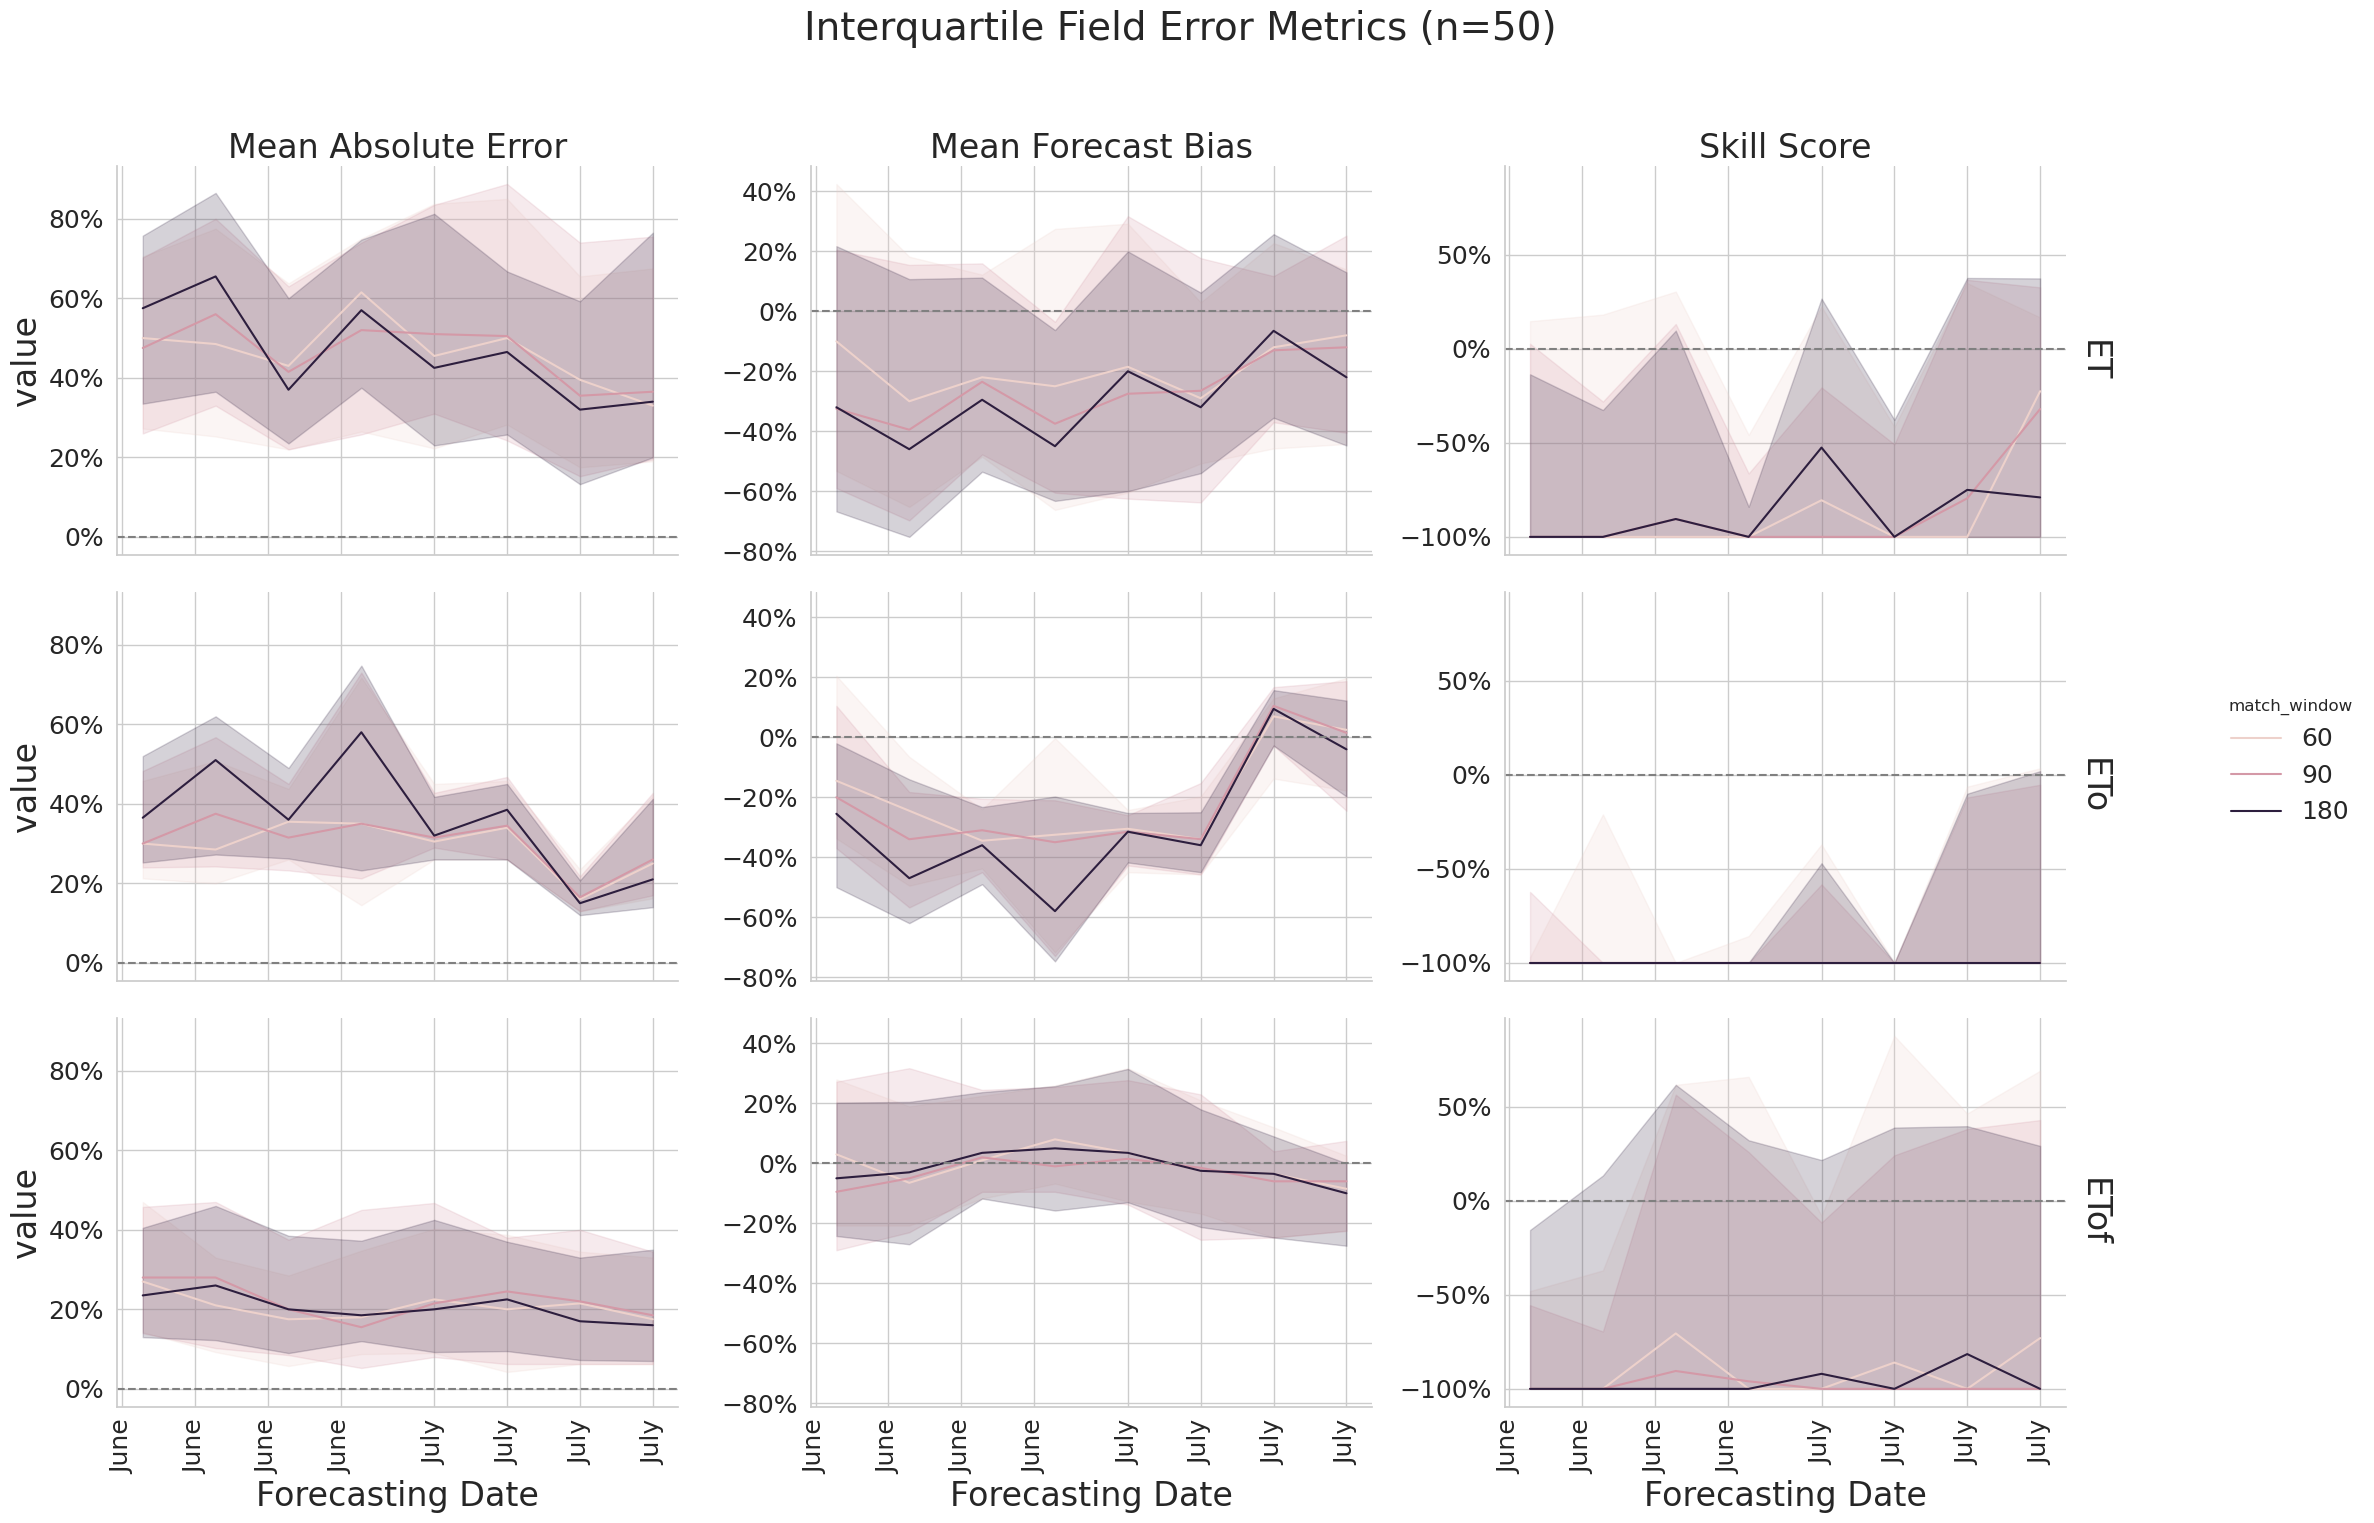

In [39]:
timeseries_rel(metrics_long, row='variable', col='name', y='value', hue='match_window',
                     errorbar=('pi', 50), estimator=np.median, as_percent=True, aspect=1.5,
                     refline={'y': 0}, export_img='monterey/window_comparisons.png',
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Interquartile Field Error Metrics (n=50)");